# Exploring Data using GLMs

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

import statsmodels.api as sm

### Helper functions

In [2]:
def prepare_glm_data(data:pd.DataFrame) -> pd.DataFrame:
    _data = data.copy()
    bool_cols = _data.select_dtypes(include='bool').columns
    _data[bool_cols] = _data[bool_cols].astype(int)
    _data = sm.add_constant(_data)
    return _data

def evaluate_model(model:sm.GLM):
    print(f'Pseudo R-squared: {model.pseudo_rsquared():.2%}')
    print(f'Deviance: {model.deviance:,.2f}')
    print(f'BIC: {model.bic_llf:,.2f}')
    print(f'Average residual: {np.mean(model.resid_response)}')
    print(f'Residuals Std: {np.std(model.resid_response)}')

### Data Load

In [3]:
DATA_PATH = r'C:/Users/Nick/Documents/Data Science/Personal projects/car-price-prediction/data/clean/'
FILE_NAME = 'data_clean_20240811.csv'

data = pd.read_csv(DATA_PATH+FILE_NAME, sep=';')
print(f'{data.shape[0]} rows, {data.shape[1]} attributes')

17705 rows, 10 attributes


### Prepare data

In [4]:
X = data.drop('Price', axis=1)
y = data['Price']

X_dummies = pd.get_dummies(X)

### Following the assumption from the EDA process...

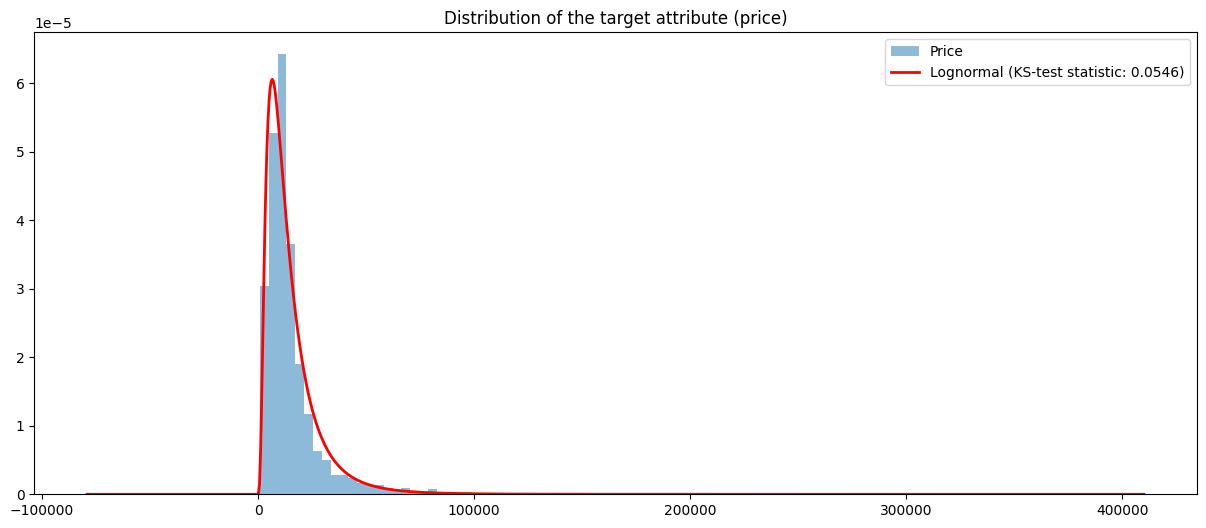

In [5]:
price_values = y.values

# fit a distribution
s, loc2, scale2 = stats.lognorm.fit(price_values)

lognorm_ks = stats.ks_1samp(price_values, stats.lognorm.cdf, args=(s, loc2, scale2)).statistic

# calculate the pdfs for plot
x_linspace = np.linspace(start=min(price_values)-80000, stop=max(price_values), num=1000)

lognorm_pdf = stats.lognorm.pdf(x_linspace, s, loc2, scale2)
# make plot
plt.figure(figsize=(15, 6))
plt.hist(price_values, bins=100, density=True, label='Price', alpha=0.5)

plt.plot(x_linspace, lognorm_pdf, lw=2, c='red', label=f'Lognormal (KS-test statistic: {lognorm_ks:.4f})')

plt.title('Distribution of the target attribute (price)')
plt.legend()
plt.show()

In [6]:
# sm.families.family.Gaussian.links

# identity link function
glm_gaussian_identity = sm.GLM(y, prepare_glm_data(X_dummies), family=sm.families.Gaussian(link=sm.genmod.families.links.Identity())).fit()
# log link function
glm_gaussian_log = sm.GLM(np.log(y), prepare_glm_data(X_dummies), family=sm.families.Gaussian(link=sm.genmod.families.links.Log())).fit()
# identity link function
glm_gaussian_inversepower = sm.GLM(np.log(y), prepare_glm_data(X_dummies), family=sm.families.Gaussian(link=sm.genmod.families.links.InversePower())).fit()

glm_gaussian_identity

In [102]:
print('---------Identity Link---------')
evaluate_model(glm_gaussian_identity)
print('---------Log Link---------')
evaluate_model(glm_gaussian_log) # best model
print('---------InvPower Link---------')
evaluate_model(glm_gaussian_inversepower)

---------Identity Link---------
Pseudo R-squared: 80.71%
Deviance: 1,991,808,872,671.62
BIC: 391,164.05
Average residual: -2.8273837040080786e-10
Residuals Std: 10431.59764823847
---------Log Link---------
Pseudo R-squared: 99.18%
Deviance: 908,227,010,123.01
BIC: 376,789.91
Average residual: -378.47052599826026
Residuals Std: 7033.904010681569
---------InvPower Link---------
Pseudo R-squared: -35.43%
Deviance: 7,585,342,945,370.55
BIC: 415,639.76
Average residual: -10556.55698757724
Residuals Std: 17405.97994540078


#### Remove independent variables with p-value greater than 5% and re-fit the model
Best fitted Gaussian model with Log link function

### Residual Analysis

In [174]:
model = glm_dropped_gaussian

1000

In [ ]:
# preform kolmogorov-smirnov goodness of fit test
known_params = {'loc':np.mean(model.resid_response), 'scale':np.std(model.resid_response)}
res = stats.goodness_of_fit(stats.norm, data=model.resid_response, known_params=known_params, statistic='ks')

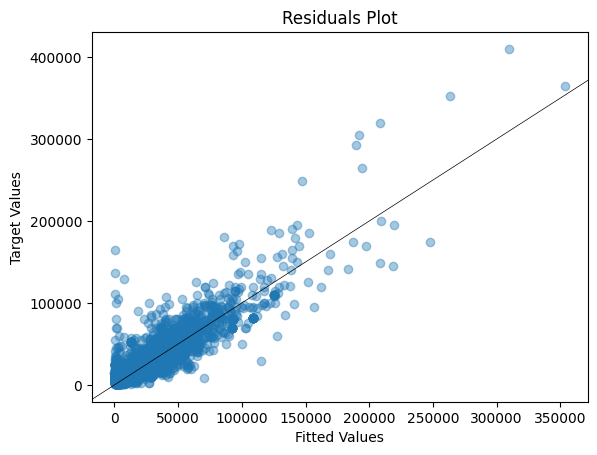

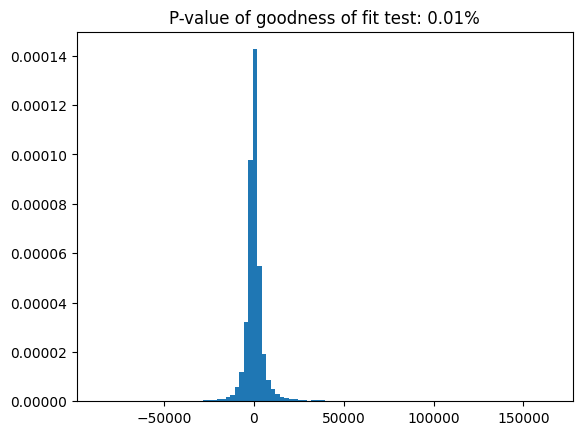

In [184]:
plt.scatter(model.fittedvalues, y, alpha=.4)
plt.axline((0,0), slope=1, color='black', lw = 0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Target Values')
plt.title('Residuals Plot')
plt.show()

plt.hist(model.resid_response, bins=100, density=True)
plt.title(f'P-value of goodness of fit test: {res.pvalue:.2%}')
plt.show()